In [51]:
import warnings
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import random
import shutil
import json
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
warnings.filterwarnings("ignore")
import cv2

In [12]:
"""
模式选择
├── 0  一键化操作
├── 1  分类已生成
├── 2  完成数据集划分
├── 3  分步可视化
├── 4  完成模型训练
├── 5  完成预测
"""
mode: int = 0

# 查看版本信息

In [13]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [14]:
# 数据集路径
data_ori = r"E:\ipynb\project\cv_exp_tensor"
data_dir = os.path.join(data_ori, 'Plant_leave_diseases_dataset_with_augmentation')

### 0、定义参数

In [15]:
def generate_categories_json(data_dir, output_file="categories.json"):
    """
    自动生成 categories.json 文件，包含数据目录下的子文件夹名称作为分类。

    Parameters:
    - data_dir (str): 数据目录的路径，每个子文件夹代表一个类别。
    - output_file (str): 输出的 JSON 文件名，默认为 categories.json。

    Returns:
    - None
    """
    try:
        # 检查数据目录是否存在
        if not os.path.exists(data_dir):
            raise FileNotFoundError(f"指定的数据目录 '{data_dir}' 不存在。")

        # 获取子文件夹列表
        categories = [folder for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]

        # 检查是否有分类
        if not categories:
            raise ValueError(f"数据目录 '{data_dir}' 下未找到任何子文件夹，无法生成分类。")

        # 生成 JSON 数据
        categories_dict = {"categories": categories}

        # 将分类信息写入 JSON 文件
        with open(output_file, "w", encoding="utf-8") as json_file:
            json.dump(categories_dict, json_file, ensure_ascii=False, indent=4)

        print(f"分类文件已成功生成: {output_file}")

    except Exception as e:
        print(f"生成分类文件时出错: {e}")

if mode < 1:
    generate_categories_json(data_dir)


In [65]:
# 数据集路径
train_dir = os.path.join(data_ori, 'train')
test_dir = os.path.join(data_ori, 'val')

# 定义数据维度和训练批次的大小
IMAGE_SHAPE = (224, 224)
input_shape = (224, 224, 3)
BATCH_SIZE = 32

# 获取类别标签
def get_files(directory):
    if not os.path.exists(directory):
        return 0
    count = 0
    for current_path, dirs, files in os.walk(directory):
        for dr in dirs:
            count += len(glob.glob(os.path.join(current_path, dr, "*")))
    return count

num_classes = len(glob.glob(os.path.join(train_dir, "*")))  # This should directly count directories under train_dir

# 加载类别信息
with open("categories.json", 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    classes = classes[0]
print(f"Classes: {classes}")
print(len(classes))


Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tom

In [17]:
def split_dataset(base_dir, output_dir, train_ratio=0.8):
    """
    将数据集按比例分割为训练集和测试集文件夹。

    Args:
        base_dir (str): 原始数据集文件夹路径。
        output_dir (str): 输出文件夹路径。
        train_ratio (float): 训练集比例，默认为 0.8。
    """
    # 确保输出目录存在
    train_dir = os.path.join(output_dir, "train")
    test_dir = os.path.join(output_dir, "val")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # 遍历每个类别文件夹
    for category in os.listdir(base_dir):
        category_path = os.path.join(base_dir, category)
        if not os.path.isdir(category_path):
            continue  # 跳过非文件夹

        # 获取当前类别的所有文件
        files = os.listdir(category_path)
        random.shuffle(files)  # 打乱顺序

        # 计算训练集和测试集的分割点
        split_point = int(len(files) * train_ratio)

        # 创建对应的类别文件夹
        train_category_dir = os.path.join(train_dir, category)
        test_category_dir = os.path.join(test_dir, category)
        os.makedirs(train_category_dir, exist_ok=True)
        os.makedirs(test_category_dir, exist_ok=True)

        # 将文件移动到训练集和测试集
        for i, file_name in enumerate(files):
            src_file = os.path.join(category_path, file_name)
            if i < split_point:
                dest_file = os.path.join(train_category_dir, file_name)
            else:
                dest_file = os.path.join(test_category_dir, file_name)
            shutil.copy(src_file, dest_file)

        print(f"类别 '{category}' 已分割：训练集 {split_point} 张，测试集 {len(files) - split_point} 张。")

if mode < 2:
    split_dataset(data_dir, data_ori, train_ratio=0.8)


## 1、数据预处理

In [18]:
# 设置数据生成器，读取源文件夹中的图像，将它们转换为‘float32”张量，并将它们(带有它们的标签)提供给网络
# 将像素值归一化在`[0,I]范围内
# 根据选择模型对图像进行调整

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    shuffle=False,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)

#数据增强
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset="training",
    shuffle=True,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)

Found 28567 images belonging to 39 classes.
Found 60648 images belonging to 39 classes.


## 2. 模型的构建与可视化

In [19]:
# 构建模型
def build_model():
    model = Sequential()
    # 第一卷积层 + 池化层
    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    # 第二卷积层 + 池化层
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 第三卷积层 + 池化层
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 全连接层
    model.add(Flatten())  # 展平操作
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))  # 防止过拟合
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  # 输出层，softmax用于多分类任务

    return model

## 可视化每层的输出

In [20]:
def show_img_map(img, model):
    # 将图片转换为合适的格式
    img_array = image.img_to_array(img) / 255.0  # 归一化到[0, 1]范围
    img_array = np.expand_dims(img_array, axis=0)

    # 获取模型所有层的输出
    layer_outputs = [layer.output for layer in model.layers]  # 获取每层的输出
    activation_model = Model(inputs=model.input, outputs=layer_outputs)  # 创建一个模型来获取每层输出

    # 获取所有层的输出
    activations = activation_model.predict(img_array)

    # 可视化每个层的输出
    for layer_idx, activation in enumerate(activations):
        # 获取当前层的特征图的维度
        layer_shape = activation.shape
        print(f"Layer {layer_idx}: {layer_shape}")

        # 如果是卷积层或池化层，通常输出是4D
        if len(layer_shape) == 4:  # (batch_size, height, width, channels)
            num_features = layer_shape[-1]  # 输出的通道数
            size = layer_shape[1]  # 高度和宽度

            # 设置图像显示的行数和列数
            columns = 8
            rows = num_features // columns
            if num_features % columns != 0:
                rows += 1

            # 创建新图形来显示当前层的所有特征图
            fig = plt.figure(figsize=(14, 7))
            for i in range(num_features):
                ax = fig.add_subplot(rows, columns, i + 1)
                ax.axis('off')
                ax.set_title(f'filter {i}')
                ax.imshow(activation[0, :, :, i], cmap='viridis')  # 显示特征图
            plt.show()

        # 如果是全连接层或其他层，通常输出是2D
        elif len(layer_shape) == 2:  # (batch_size, units)
            print(f"Layer {layer_idx} is not a convolutional layer, skipping visualization.")
            continue

        else:
            print(f"Unexpected layer output shape: {layer_shape}, skipping visualization.")
            continue


## 3.模型训练

In [21]:
def model_train(model):
    # Specify loss function and optimizer
    lr = 0.001
    epochs = 5
    opt = Adam(learning_rate=lr)

    # Compile the model with the optimizer, loss function, and metrics
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(
        train_generator,
        batch_size=BATCH_SIZE,
        epochs=epochs,
        validation_data=test_generator,
        verbose=1
    )

    # Evaluate the model
    score, accuracy = model.evaluate(test_generator, verbose=1)

    # Print the evaluation results
    print(f"Test score is {score}")
    print(f"Test accuracy is {accuracy}")

    # Save the model
    export_path = os.path.join(data_ori,f"saved_models/model_1")  # Correctly format the export path
    model.save(export_path)  # Save the model to the specified path

    return history, export_path


## 4.预测

In [59]:
# 示例：设置全局常量
IMAGE_SHAPE = (224, 224)  # 图像尺寸

def load_image(filename):
    """
    加载并预处理图像。

    Args:
        filename (str): 图像文件名。
    Returns:
        np.ndarray: 预处理后的图像数组。
    """
    img_file = os.path.join(test_dir, filename)
    print('Loading image:', img_file)

    # 加载图像
    img = cv2.imread(img_file)
    if img is None:
        raise FileNotFoundError(f"Image not found: {img_file}")

    # 调整图像大小
    img = cv2.resize(img, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
    # 归一化
    img = img / 255.0
    return img

def predict(img, model):
    """
    使用模型预测图像的类别。

    Args:
        img (np.ndarray): 预处理后的图像。
        model (keras.Model): 已加载的模型。
    Returns:
        dict: 预测类别及其概率。
    """
    probabilities = model.predict(np.asarray([img]))[0]  # 模型预测
    class_idx = np.argmax(probabilities)  # 获取最大概率的类别索引
    return {classes[class_idx]: probabilities[class_idx]}

def predict_reload(img, reloaded_model, classes):
    """
    使用重新加载的模型预测图像的类别。

    Args:
        img (np.ndarray): 预处理后的图像。
        reloaded_model (keras.Model): 重新加载的模型。
        classes (list): 类别名称的列表，顺序与模型输出一致。

    Returns:
        dict: 预测类别及其概率。
    """
    # 模型预测
    probabilities = reloaded_model.predict(np.asarray([img]))[0]
    
    # 获取最大概率的类别索引
    class_idx = np.argmax(probabilities)
    
    # 打印调试信息
    print(f"预测概率: {probabilities}")
    print(f"预测的类别索引: {class_idx}")
    
    # 返回类别和其对应的概率
    return {classes[class_idx]: probabilities[class_idx]}





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 33, 33, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

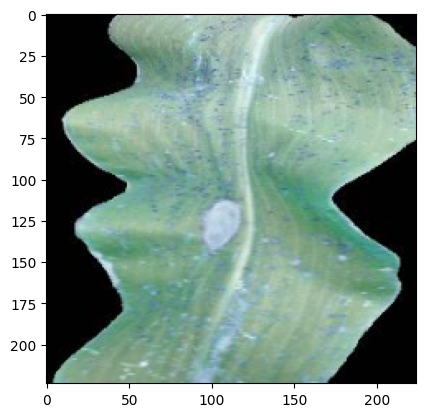

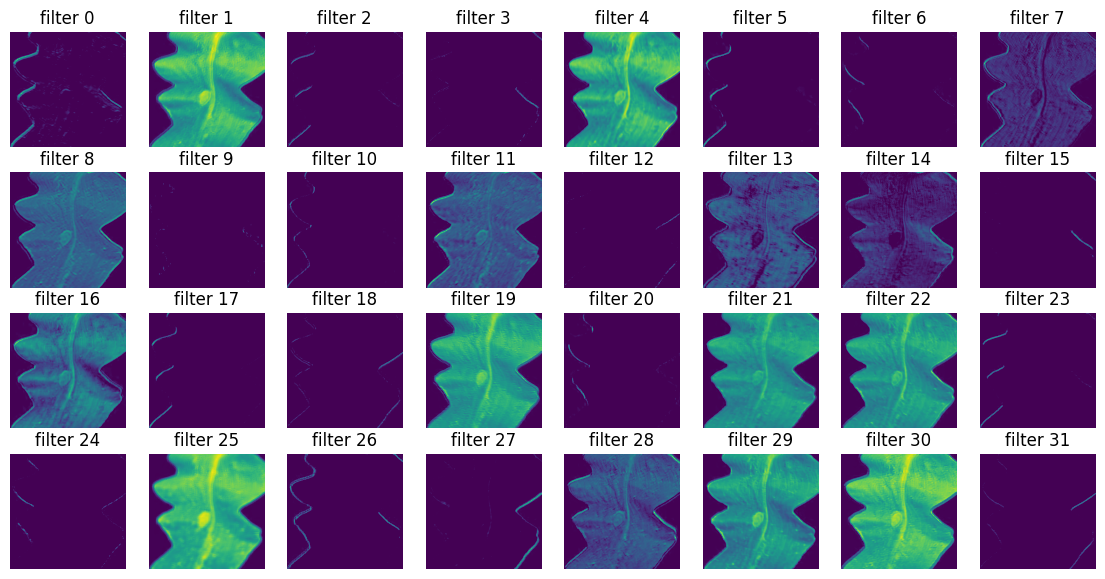

Layer 1: (1, 73, 73, 32)


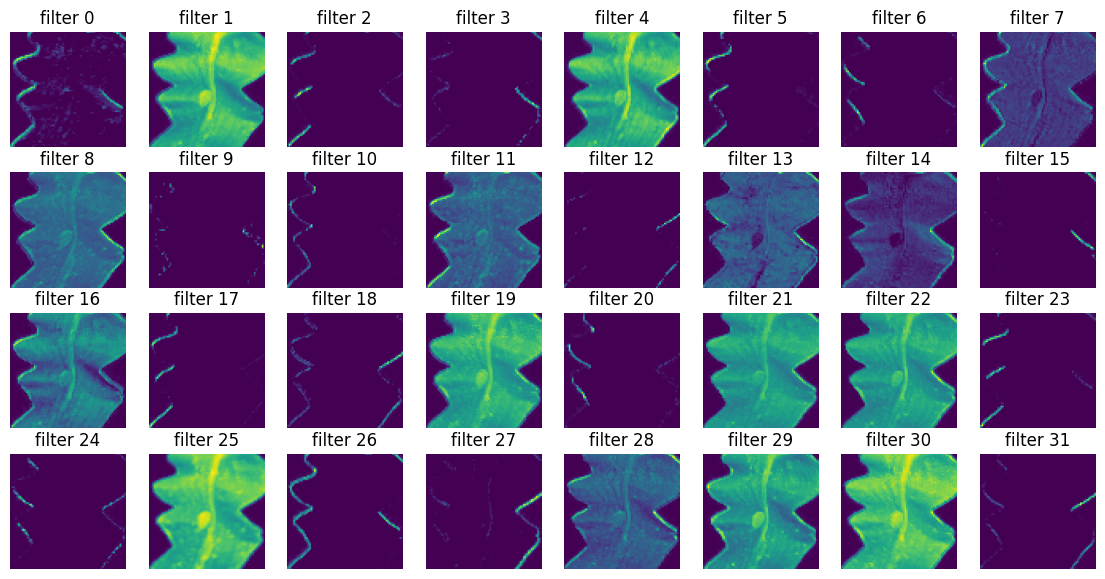

Layer 2: (1, 71, 71, 32)


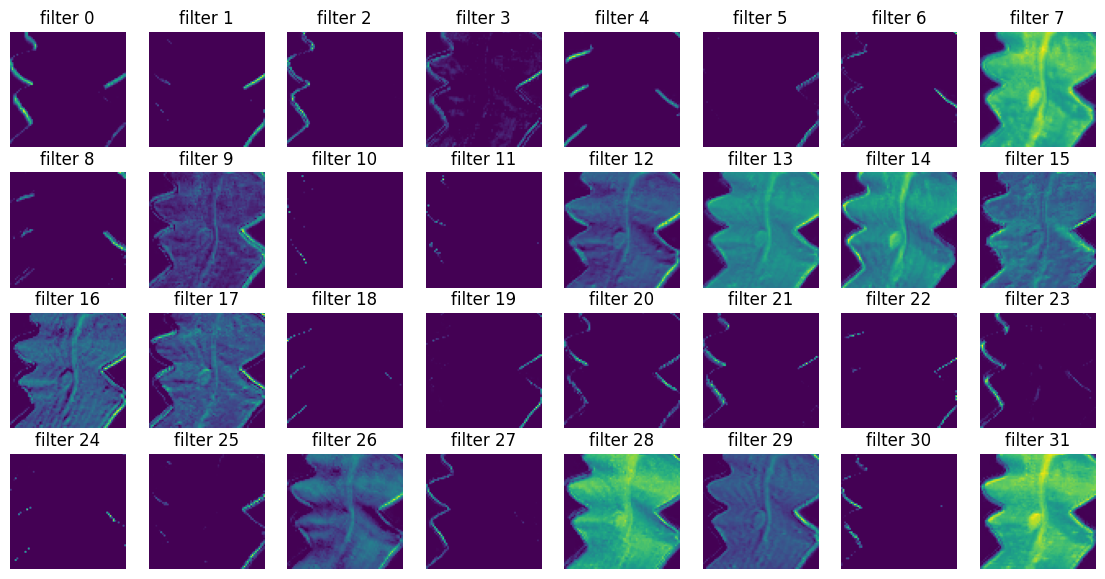

Layer 3: (1, 35, 35, 32)


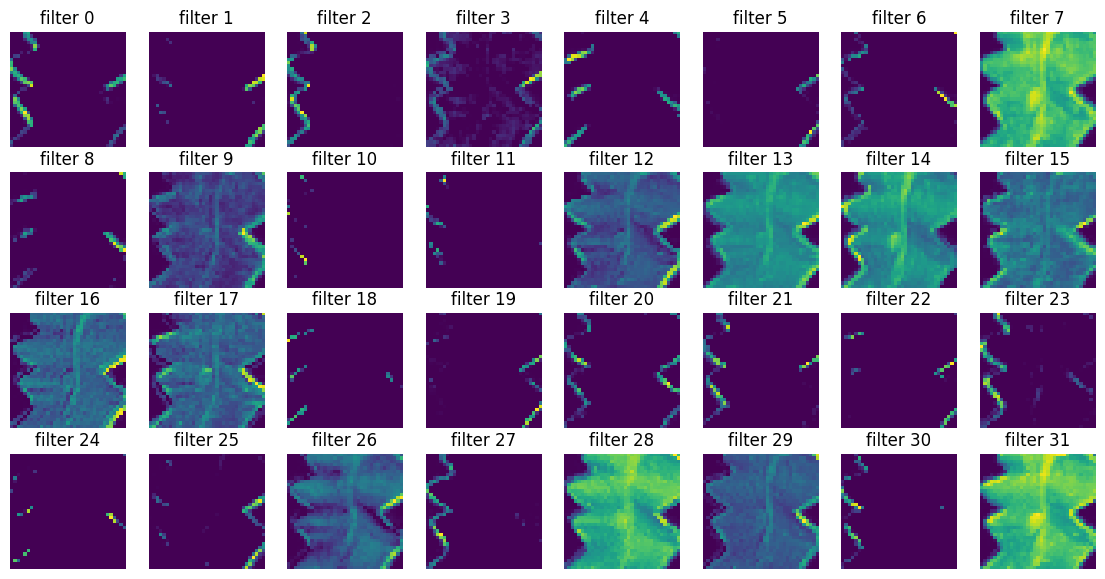

Layer 4: (1, 33, 33, 64)


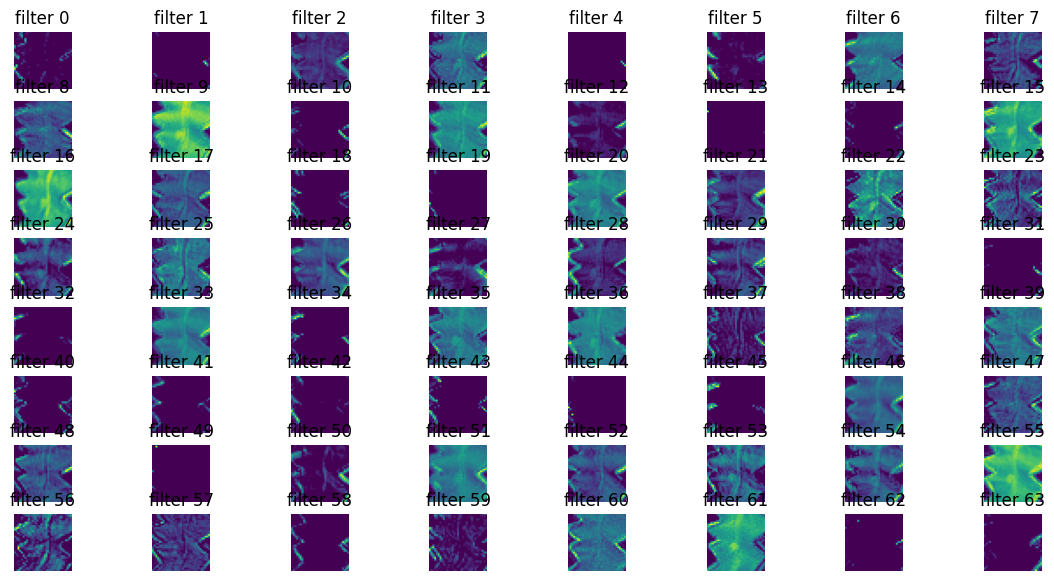

Layer 5: (1, 16, 16, 64)


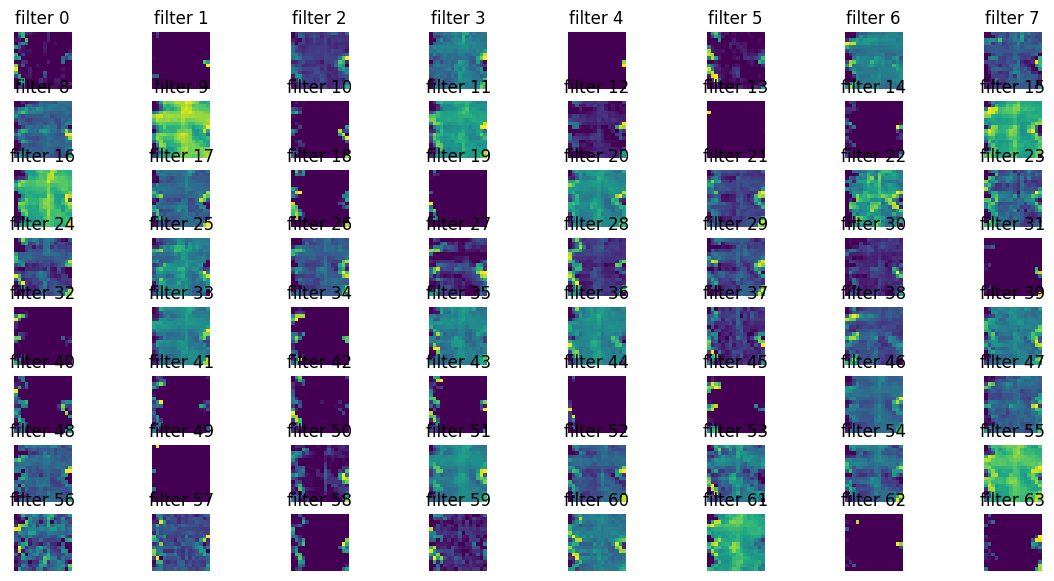

Layer 6: (1, 16384)
Layer 6 is not a convolutional layer, skipping visualization.
Layer 7: (1, 512)
Layer 7 is not a convolutional layer, skipping visualization.
Layer 8: (1, 512)
Layer 8 is not a convolutional layer, skipping visualization.
Layer 9: (1, 128)
Layer 9 is not a convolutional layer, skipping visualization.
Layer 10: (1, 39)
Layer 10 is not a convolutional layer, skipping visualization.


In [23]:
model = build_model()
model.summary()

if mode < 3:
    # 特征映射可视化
    img1 = load_image(os.path.join(test_dir, "test.jpg"))
    plt.imshow(img1)
    show_img_map(img1, model)  # 修正调用，传递 `model`

Epoch 1/5
1896/1896 [==============================] - 813s 429ms/step - loss: 1.6113 - accuracy: 0.5297 - val_loss: 0.9852 - val_accuracy: 0.6955
Epoch 2/5
1896/1896 [==============================] - 738s 389ms/step - loss: 0.8176 - accuracy: 0.7434 - val_loss: 0.6445 - val_accuracy: 0.7956
Epoch 3/5
1896/1896 [==============================] - 737s 389ms/step - loss: 0.6000 - accuracy: 0.8086 - val_loss: 0.5315 - val_accuracy: 0.8364
Epoch 4/5
1896/1896 [==============================] - 736s 388ms/step - loss: 0.4969 - accuracy: 0.8412 - val_loss: 0.4202 - val_accuracy: 0.8625
Epoch 5/5
893/893 [==============================] - 71s 79ms/step - loss: 0.2566 - accuracy: 0.9157
Test score is 0.25664815306663513
Test accuracy is 0.9157069325447083


INFO:tensorflow:Assets written to: saved_models/model_1731771774\assets


INFO:tensorflow:Assets written to: saved_models/model_1731771774\assets


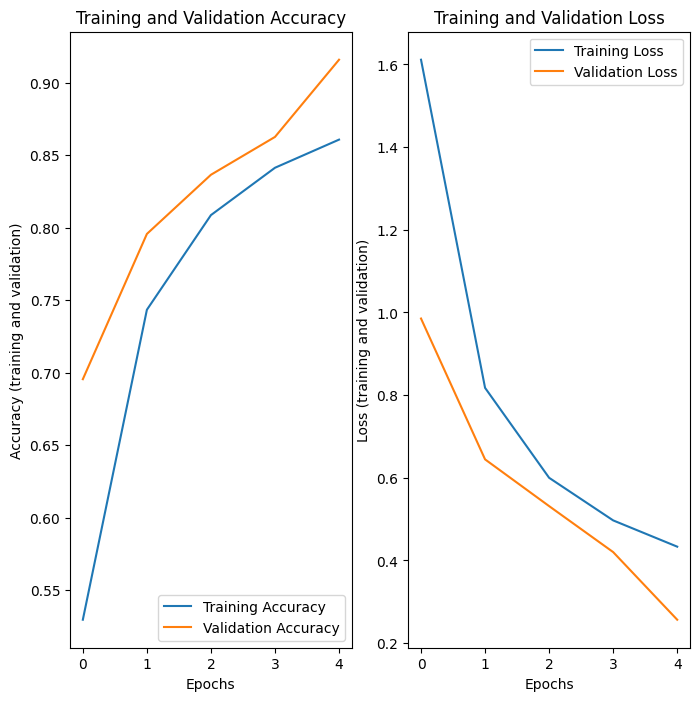

In [24]:
if mode < 4:
    # 2. 模型训练
    history, export_path = model_train(model)
    
    # 打印训练曲线
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))  # 动态确定训练步数
    
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.ylabel("Accuracy (training and validation)")
    plt.xlabel("Epochs")
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.ylabel("Loss (training and validation)")
    plt.xlabel("Epochs")
    plt.show()

图像: image (48).JPG
Loading image: E:\ipynb\project\cv_exp_tensor\evaluate\image (48).JPG
1/1 [==============================] - 0s 80ms/step
预测概率: [4.24260733e-08 9.04992595e-02 5.57504693e-12 1.28484373e-06
 1.45121637e-10 1.50606255e-07 2.61134279e-08 3.61706644e-01
 1.09782723e-12 2.95810186e-12 2.51803837e-15 1.03236069e-15
 2.01306277e-10 2.83748380e-09 1.47126842e-11 1.72303860e-08
 6.88168411e-10 7.72795730e-08 2.23917933e-08 1.93177687e-03
 5.44165313e-01 5.25830117e-12 3.53084589e-10 2.31809783e-04
 1.07422045e-08 1.51357881e-05 7.53165434e-15 1.37826016e-13
 1.50511978e-10 2.80734533e-11 2.06623099e-06 7.95861126e-07
 1.10962112e-07 1.44476572e-03 7.70925634e-09 2.93047719e-07
 1.61595858e-11 3.34901188e-07 1.59323683e-12]
预测的类别索引: 20
预测:class:Pepper,_bell___healthy, confidence: 0.544165313243866
Loading image: E:\ipynb\project\cv_exp_tensor\evaluate\image (48).JPG


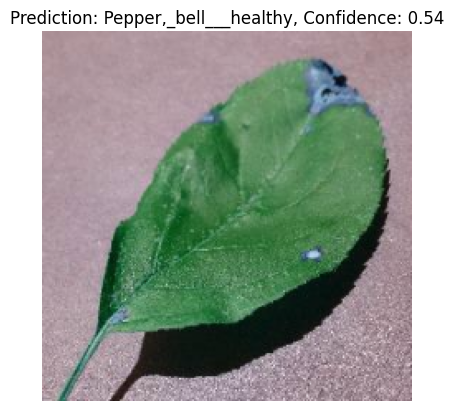

图像: image (44).JPG
Loading image: E:\ipynb\project\cv_exp_tensor\evaluate\image (44).JPG
1/1 [==============================] - 0s 24ms/step
预测概率: [1.25314167e-03 3.96775939e-02 5.41234294e-05 4.18314457e-01
 2.53148214e-03 7.74073135e-03 1.36161176e-03 2.01865837e-01
 9.57119028e-06 2.49838286e-06 4.20729111e-06 7.99843619e-05
 2.63927132e-02 1.22294286e-02 2.16357905e-04 4.83337208e-04
 1.93375628e-02 5.55278020e-05 5.58514264e-04 8.06333683e-03
 4.60504144e-02 1.69642644e-05 1.51435705e-03 3.01663438e-03
 4.40946827e-03 1.13266699e-01 1.45384220e-05 4.57863498e-05
 1.37789521e-05 6.58250647e-04 9.03812051e-03 3.43478471e-02
 7.77580729e-03 3.75500694e-03 2.22429857e-02 1.62296137e-03
 1.16576115e-02 2.62071844e-04 5.86510541e-05]
预测的类别索引: 3
预测:class:Apple___healthy, confidence: 0.41831445693969727
Loading image: E:\ipynb\project\cv_exp_tensor\evaluate\image (44).JPG


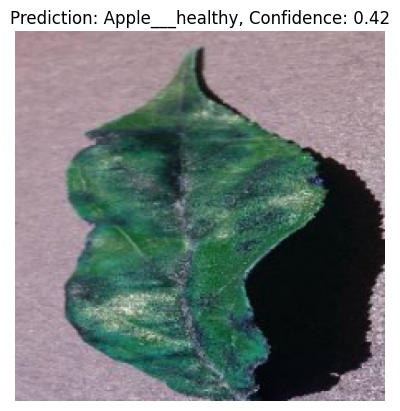

In [66]:
export_path = os.path.join(data_ori,'saved_models', 'model_1')
# 3. 预测
reloaded = keras.models.load_model(export_path)
test_images_dir = os.path.join(data_ori,"evaluate")  # 测试图像目录

# 随机选择两张图片进行预测
for idx, filename in enumerate(random.sample(os.listdir(test_images_dir), 2)):
    filepath = os.path.join(test_images_dir, filename)
    print(f"图像: {filename}")

    img = load_image(filepath)
    prediction = predict_reload(img, reloaded,classes)
    class_name = list(prediction.keys())[0]
    confidence = list(prediction.values())[0]
    print(f"预测:class:{class_name}, confidence: {confidence}")

    plt.imshow(load_image(filepath))
    plt.title(f"Prediction: {class_name}, Confidence: {confidence:.2f}")
    plt.axis('off')
    plt.show()